### Check these out:

- https://github.com/frisoI3GEO/fun_with_code_math_geophysics/blob/main/wavelet_estimation/Wavelet%20Estimation_public_version.ipynb
- https://pylops.readthedocs.io/en/latest/gallery/plot_wavest.html


# Wavelet estimation

Let's import a number of Python libraries that we'll use throughout the tutorial. If you don't already have `bruges`, and `pylops` you will need to do this:

    pip install bruges pylops

Then re-start the kernel in this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Read in the data

<code>r</code> is the reflection coefficient series (in the time domain), <code>s</code> is the seismic trace, <code>dt</code> is the sample rate (in seconds), and <code>t</code> is the travel-time basis for both series.

In [2]:
r = np.load('../data/rpp.npy')
s = np.load('../data/seismic.npy')

dt = 0.004  # Sample rate in seconds.
t = np.arange(s.size) * dt

Plot the reflectivity and the seismic trace side by side.

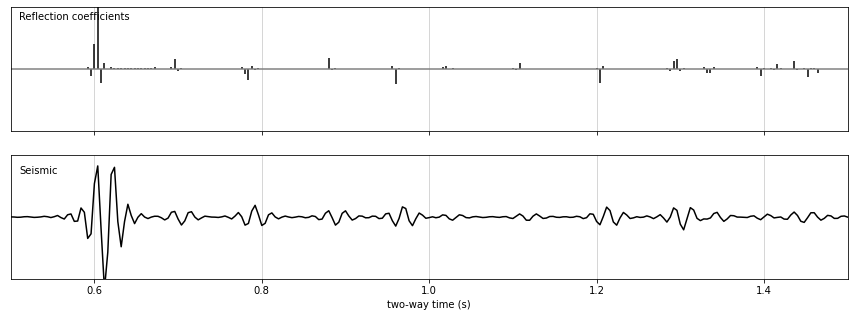

In [3]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(15, 5))

# Reflectivity track
ax = axs[0]
ax.stem(t, r, 'k', markerfmt='none', basefmt='gray')
ax.set_yticks([])
ax.set_xlim(0.5, 1.5)
ax.set_ylim(-0.25, 0.25)
ax.text(0.51, 0.2, "Reflection coefficients")
ax.grid(c='k', alpha=0.2)

# Seismic track
ax = axs[1]
ax.plot(t, s, 'k')
ax.fill_betweenx(t, s, 0, s > 0, color='k', alpha=1.0)
ax.set_xlim(0.5, 1.5)
ax.set_ylim(-0.1, 0.1)
ax.set_xlabel('two-way time (s)')
ax.set_yticks([])
ax.text(0.51, 0.07, "Seismic")
ax.grid(c='k', alpha=0.2)
plt.show()

## Ricker

Compute the spectrum of the seismic trace.

In [4]:
S = np.abs(np.fft.rfft(s))
f = np.fft.rfftfreq(len(s), d=dt)

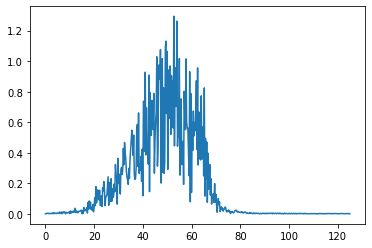

In [5]:
plt.plot(f, S)

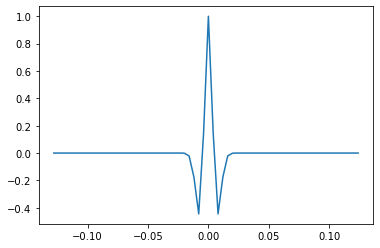

In [6]:
import bruges as bg

wr, tr = bg.filters.ricker(0.256, dt=dt, f=50, return_t=True)

plt.plot(tr, wr)

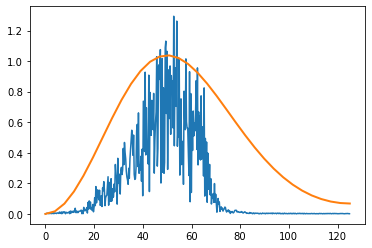

In [7]:
Wr = np.abs(np.fft.rfft(wr))
fw = np.fft.rfftfreq(len(wr), d=dt)

plt.plot(f, S)
plt.plot(fw, Wr/2, lw=2)

This doesn't look very promising, let's try another wavelet.

## Ormsby

Basically a bandpass filter, the Ormsby defines a trapezoidal shape. Try to approximate the shape with a trapezoid:

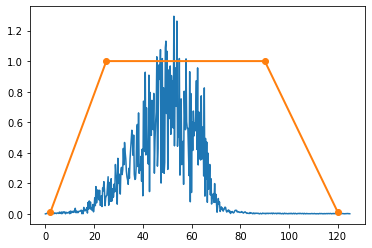

In [8]:
freqs = [2, 25, 90, 120]  # <--- Adjust these numbers to make the shape fit.

plt.plot(f, S)
plt.plot(freqs, [0.01, 1, 1, 0.01], 'C1o-', lw=2, ms=6)

Bruges has a function for creating an Ormsby wavelet. We need to pass in the the <code>duration</code>, the sample rate <code>dt</code> and the four bandpass frequencies, <code>freqs</code> as a list.

In [9]:
wo, to = bg.filters.ormsby(0.256, dt=dt, f=freqs, return_t=True)

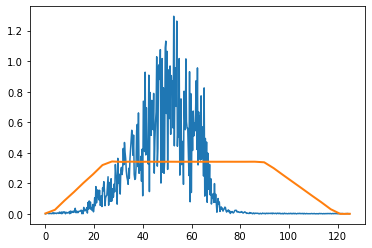

In [10]:
Wo = np.abs(np.fft.rfft(wo))
fo = np.fft.rfftfreq(len(wo), d=dt)

plt.plot(f, S)
plt.plot(fo, Wo/4, lw=2)

Let's plot the Ormsby wavelet in the time domain.

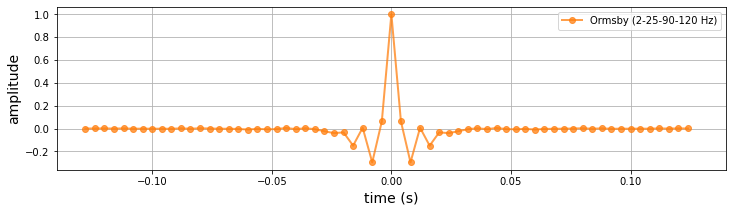

In [20]:
fig, ax = plt.subplots(figsize=(12,3))

ax.plot(to, wo, 'C1o-', lw=2, alpha=0.75, 
        label='Ormsby ({}-{}-{}-{} Hz)'.format(*freqs))

ax.legend(loc=1)
ax.set_xlim(-0.140,0.140)
ax.set_xlabel('time (s)', fontsize=14)
ax.set_ylabel('amplitude', fontsize=14)
ax.grid()

plt.show()

It looks all blocky! But that's okay, it's just what wavelets look like. You're used to seeing them interpolated to look higher resolution:

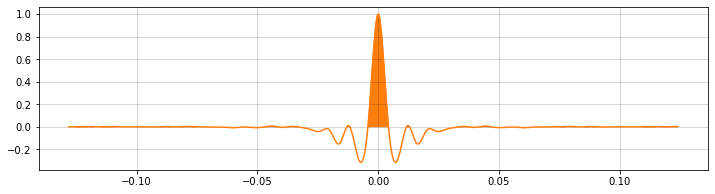

In [21]:
from scipy.interpolate import interp1d

func = interp1d(to, wo, kind='cubic')
tnew = np.linspace(to.min(), to.max(), 1000)
ormnew = func(tnew)

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(tnew, ormnew, 'C1-')
ax.fill_between(tnew, ormnew, 0, ormnew>0, color='C1', interpolate=True)
plt.grid(c='k', alpha=0.2)

It's the same data!

### EXERCISE

- Convolve this `wo` wavelet with the RC series.
- Compare the resulting synthetic with the seismic trace we loaded.
- Make the synthetic with `bruges.filters.ricker` with about the same frequency content. (It won't be exactly the same of course.) How does it compare?
- Use `bruges.filters.rotate_phase()` to rotate the phase of the estimated wavelet. Can you get a better fit? (You could add an ipywidgets slider to change it interactively.)
- If you want, you can use `np.corrcoeff(signal1, signal2)[0][1]` to compare two signals.

In [11]:
from ipywidgets import interact

@interact(phi=(-180, 180, 10))
def main(phi):
    w = bg.filters.rotate_phase(wo, phi, degrees=True)

    syn = np.convolve(r, w, mode='same')
    crcf = np.corrcoef(s, syn)[0, 1]

    plt.figure(figsize=(15, 3))
    plt.plot(t, syn)
    plt.plot(t, 3 * s)

    plt.xlim(0.5, 1.5)
    plt.ylim(-0.35, 0.35)
    plt.title(f"{crcf:.4f}", size=20)
    
    plt.show()
    return

interactive(children=(IntSlider(value=0, description='phi', max=180, min=-180, step=10), Output()), _dom_class…

Look at the CrCf of all phase shifts:

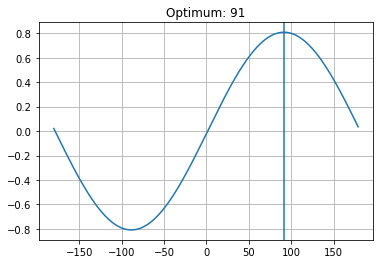

In [13]:
crcfs = []
phis = range(-180, 180)
for phi in phis:
    w = bg.filters.rotate_phase(wo, phi, degrees=True)
    syn = np.convolve(r, w, mode='same')
    crcfs.append(np.corrcoef(s, syn)[0, 1])
opt = phis[np.argmax(crcfs)]

plt.plot(phis, crcfs)
plt.title(f"Optimum: {opt}")
plt.axvline(opt)
plt.grid()
plt.show()

# Wavelet estimation by autocorrelation

If we assume the earth’s reflectivity spectrum to be flat, then the shape of the spectra can be attributed to the shape of the wavelet. By doing an autocorrelation of the trace, that is, correlating the trace with itself, we get a zero-phase signal from the amplitude spectrum of the trace.

In [14]:
L = 64  # Desired length in samples.

acorr = np.correlate(s, s, mode='same')

wa = acorr[s.size//2 - L//2:s.size//2 + L//2]

ta = np.arange(0, wa.size) * dt - 0.128

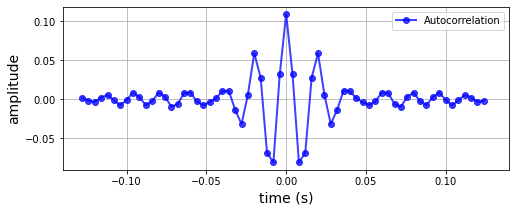

In [15]:
fig, ax = plt.subplots(figsize=(8,3))

ax.plot(ta, wa, 'bo-', lw=2, alpha=0.75, label='Autocorrelation')
ax.legend(loc=1)
ax.set_xlim(-0.140,0.140)
ax.set_xlabel('time (s)', fontsize=14)
ax.set_ylabel('amplitude', fontsize=14)
ax.grid()

plt.show()

We'll need a function to normalize a signal to its max value.

In [141]:
def normalize(data):
    return data / np.amax(data)

...and the ends are rather ragged so let's apply a taper:

In [17]:
wa = normalize(wa) * np.blackman(wa.size)

Let's compare the autocorrelation of the trace with the Ormsby wavelet that we just made.

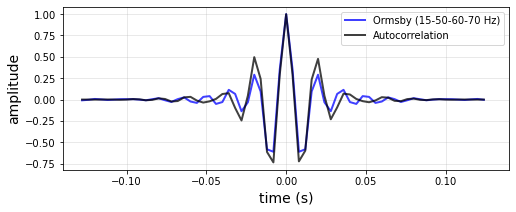

In [18]:
fig, ax = plt.subplots(figsize=(8,3))

ax.plot(to, wo, 'blue', lw=2, alpha=0.75, label='Ormsby ({}-{}-{}-{} Hz)'.format(*freqs))
ax.plot(ta, wa, 'k', lw=2, alpha=0.75, label='Autocorrelation')

ax.legend()
ax.set_xlim(-0.14, 0.14)
ax.set_xlabel('time (s)', fontsize=14)
ax.set_ylabel('amplitude', fontsize=14)
ax.grid('k', alpha=0.35)

plt.show()

### EXERCISE

Let's compare a new synthetic, using this wavelet, to the previous synthetic!

In [21]:
WAVELETS = {
    'ricker': bg.filters.ricker(0.128, 0.004, 35)
    'ormsby': wo,
    'autocorr': wa,
}


@interact(phi=(-180, 180, 10), wavelet=WAVELETS.keys())
def main(phi, wavelet):

    w = WAVELETS.get(wavelet)
    w = bg.filters.rotate_phase(w, phi, degrees=True)    
    syn = np.convolve(r, w, mode='same')
    crcf = np.corrcoef(s, syn)[0, 1]

    plt.figure(figsize=(15, 3))
    plt.plot(t, syn, label="syn")
    plt.plot(t, 3 * s, label='seismic')

    plt.xlim(0.5, 1.5)
    plt.ylim(-0.35, 0.35)
    plt.title(f"{wavelet.upper()}: {crcf:.4f}", size=20)
    plt.legend()
    
    plt.show()
    return

/Users/matt/opt/miniconda3/envs/geocomp/lib/python3.8/site-packages/bruges/filters/wavelets.py:205: FutureWarning: In future releases, return_t will be True by default.
  warnings.warn("In future releases, return_t will be True by default.", FutureWarning)


interactive(children=(IntSlider(value=0, description='phi', max=180, min=-180, step=10), Dropdown(description=…

# Wavelet estimation by spectral division

In principal, since "convolution in time is multiplication in frequency", we should be able to discover the wavelet's spectrum by taking the quotient of the data and  reflectivity spectrums.

The thing is, there's also noise mixed in there, and the filter effect of the recording system. We're really just going to end up with an operator that, when convolved with the reflectivity, gives the seismic back. It's a bit cheaty.

In [198]:
spectra = {
    'data': (f, 20 * np.log10(S)),
    'reflectivity': (f, 20 * np.log10(np.abs(np.fft.rfft(r)))),
    'wavelet maybe': (f, 20 * np.log10(S/np.abs(np.fft.rfft(r))))
}

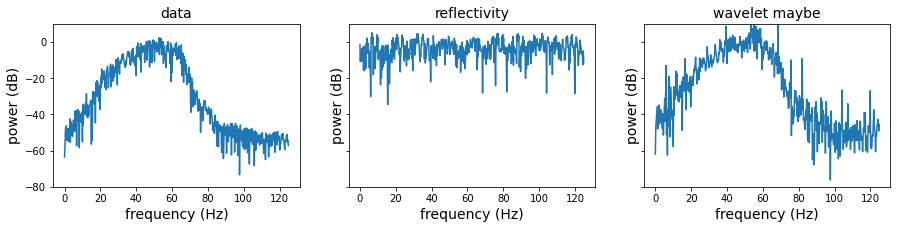

In [199]:
fig, axs = plt.subplots(ncols=len(spectra), figsize=(15,3), sharey=True)

for ax, (name, (f_, Pxx)) in zip(axs, spectra.items()):
    ax.plot(f_, Pxx)
    ax.set_title(name, fontsize=14)
    ax.set_ylabel('power (dB)', fontsize=14)
    ax.set_xlabel('frequency (Hz)', fontsize=14)
    ax.set_ylim(-80, 10)

plt.show()

So if we take the inverse FFT of that new spectrum, it might make a wavelet.

Let's write a function for doing spectral division. 

In [200]:
def spectral_division(duration, dt, reflectivity, data):
    """
    Estimate the wavelet's spectrum by dividing the data's spectrum
    by the reflectivity spectrum.
    
    Then take the inverse FFT to recover the time-domain wavelet.
    """
    seis_fft = np.fft.fft(data)
    ref_fft = np.fft.fft(reflectivity)

    wavelet_spec = seis_fft / ref_fft
    wavelet_div = np.fft.ifft(wavelet_spec)
    
    # Rearrange things a bit.
    w_ = np.fft.fftshift(wavelet_div)
    n = int(duration / dt)
    t = np.arange(-duration/2, duration/2, dt)
    L = int(w_.size // 2)
    w = normalize(w_[L-n//2:L+n//2])

    return w, t

Now let's make a plot of this signal obtained by doing spectral division.

In [190]:
ws, ts = spectral_division(0.256, dt, r, s)

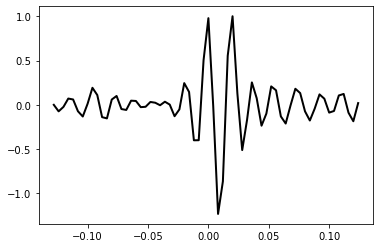

In [191]:
plt.plot(ts, ws.real, 'k', lw=2)
plt.show()

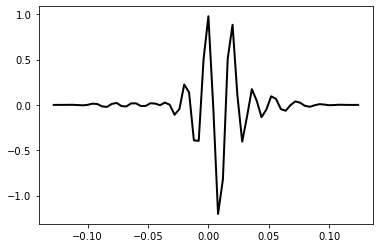

In [192]:
ws *=  np.blackman(ws.size)

plt.plot(ts, ws.real, 'k', lw=2)
plt.show()

In [197]:
@interact(phi=(-180, 180, 10))
def plot(phi):
    ws_ = bg.filters.rotate_phase(ws.real, phi=phi, degrees=True)
    plt.plot(ts, ws_)
    plt.ylim(-1.1, 1.1)
    return

interactive(children=(IntSlider(value=0, description='phi', max=180, min=-180, step=10), Output()), _dom_class…

# Wavelet estimation by least squares

In [334]:
import scipy.linalg as la
from sklearn import linear_model

reg = linear_model.Ridge(alpha=1, fit_intercept=False)
R = la.toeplitz(r)
reg.fit(R, s)
wavelet_ = reg.coef_
wl = np.concatenate([wavelet_[32:1:-1], wavelet_[:33]])
wl = normalize(wl)
wl *= np.blackman(wl.size)

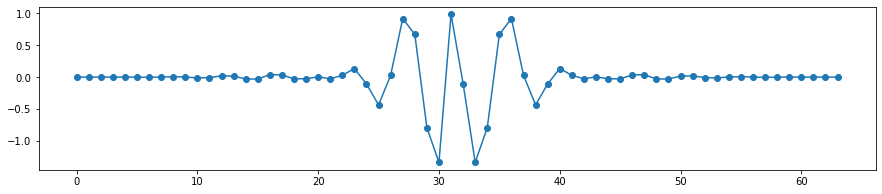

In [335]:
plt.figure(figsize=(15, 3))
plt.plot(wl, 'o-')

# Create synthetics

In [336]:
WAVELETS = {
    'ricker': bg.filters.ricker(0.128, 0.004, 35),
    'ormsby': wo,
    'autocorr': wa,
    'spectral div': ws.real,
    'leastsq': wl,
}


_ = interact(main, phi=(-180, 180, 10), wavelet=WAVELETS.keys())

/Users/matt/opt/miniconda3/envs/geocomp/lib/python3.8/site-packages/bruges/filters/wavelets.py:205: FutureWarning: In future releases, return_t will be True by default.
  warnings.warn("In future releases, return_t will be True by default.", FutureWarning)


interactive(children=(IntSlider(value=0, description='phi', max=180, min=-180, step=10), Dropdown(description=…

Finally, we can compute the correlation coefficient between the synthetic and the data.

In [285]:
np.corrcoef(s, synth)[0][1]

0.5446845247159252

## References

- Bianco, E., 2014, Geophysical tutorial: Well-tie calculus: The Leading
Edge, 33, no. 6, 674–677, http://dx.doi.org/10.1190/tle33060674.1.


- Brown, R. L., W. McElhattan, and D. J. Santiago, 1988, Wavelet
estimation: An interpretive approach: The Leading Edge, 7, no.
12, 16–19, http://dx.doi.org/10.1190/1.1439470.


- Martin, G., R. Wiley, and K. Marfurt, 2006, Marmousi2: An elastic
upgrade for Marmousi: The Leading Edge, 25, no. 2, 156–
166, http://dx.doi.org/10.1190/1.2172306.

<hr />
<img src="https://avatars1.githubusercontent.com/u/1692321?v=3&s=200" style="float:left;" width="50px" /><p style="color:gray; float:left; margin-left:12px;">Code and text © 2016 <a href="http://www.agilegeoscience.com/">Agile Geoscience</a> — <a href="https://creativecommons.org/licenses/by/4.0/">CC-BY</a> — Have fun!&nbsp;&nbsp;&nbsp;</p>